In [ ]:
#print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

!pip install astroNN scikit-image opencv-python-headless mahotas qiskit

# imported dataset
from astroNN.datasets import galaxy10

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# image processing imports
import cv2
from skimage.feature import local_binary_pattern
from skimage.filters import gabor
import mahotas

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers, utils
from tensorflow.keras.utils import to_categorical

In [ ]:
# Load and filter to classes 2: Round Smooth Galaxies, 3: In-between Round Smooth Galaxies, 5: Barred Spiral Galaxies, 7: Unbarred Loose Spiral Galaxies
images, labels = galaxy10.load_data()
desired_classes = [2, 3, 5, 7]
mask = np.isin(labels, desired_classes)
images, labels = images[mask], labels[mask]

for cls in desired_classes:
    print(f"Class {cls}: {np.sum(labels == cls)} images")

# downscale img size (less ram used)
images = np.array([cv2.resize(img, (64, 64)) for img in images], dtype=np.float32) / 255.0
print(f"Downscaled images shape: {images.shape}  (height, width, channels)")


In [ ]:
# labels to 0–3
class_to_index = {orig: new for new, orig in enumerate(desired_classes)}
labels_idx = np.array([class_to_index[l] for l in labels])

labels = to_categorical(labels_idx, num_classes=len(desired_classes)).astype(np.float32)
images = images.astype(np.float32)

print(f"Images shape: {images.shape}")
print(f"One-hot labels shape: {labels.shape}")
print(f"Number of classes: {labels.shape[1]}")

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Sample from Each Selected Class', fontsize=16)
for idx, orig_cls in enumerate(desired_classes):
    i = np.where(labels_idx == idx)[0][0]
    ax = axs.flat[idx]
    ax.imshow(images[i])
    ax.set_title(f"Original {orig_cls} → mapped {idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# SVM feature extraction
!pip install pywavelets mahotas --quiet

import pywt
from skimage.feature import local_binary_pattern, hog
from skimage.filters import gabor
from skimage.measure import regionprops, label
from mahotas.features import zernike_moments, haralick

def extract_color_histogram(img, bins=16):
    chans = cv2.split((img*255).astype('uint8'))
    feats = []
    for c in chans:
        hist = cv2.calcHist([c],[0],None,[bins],[0,256])
        feats.extend((hist.flatten()/hist.sum()).astype(np.float32))
    return np.array(feats, np.float32)

def extract_lbp(img, P=8, R=1):
    gray = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P, R, method='uniform')
    hist,_ = np.histogram(lbp, bins=np.arange(0,P+3), range=(0,P+2))
    return (hist/hist.sum()).astype(np.float32)

def extract_gabor_feat(img, frequency=0.6):
    gray = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    real, _ = gabor(gray, frequency=frequency)
    return np.array([real.mean(), real.var()], np.float32)
"""
def extract_edges(img):
    gray = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray,100,200)
    return np.array([edges.mean(), edges.std()], np.float32)

def extract_hu_moments(img):
    gray = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    hu = cv2.HuMoments(cv2.moments(gray)).flatten()
    return np.log(np.abs(hu)+1e-7).astype(np.float32)

def extract_orb(img, desc_len=32):
    gray = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    orb = cv2.ORB_create()
    _, desc = orb.detectAndCompute(gray, None)
    if desc is None:
        return np.zeros(desc_len, np.float32)
    return desc.mean(axis=0).astype(np.float32)
  """

def extract_hog(img):
    gray = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    feats,_ = hog(gray, orientations=9, pixels_per_cell=(8,8),
                 cells_per_block=(2,2), visualize=True, feature_vector=True)
    return feats.astype(np.float32)

def extract_zernike(img, radius=32, degree=8):
    gray = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    return zernike_moments(gray, radius, degree).astype(np.float32)

def extract_haralick(img):
    gray = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    feats = haralick(gray)
    return feats.mean(axis=0).astype(np.float32)

def extract_wavelet(img):
    gray = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY)/255.0
    cA, (cH, cV, cD) = pywt.dwt2(gray, 'db1')
    return np.array([cA.mean(), cA.std(),
                     cH.mean(), cH.std(),
                     cV.mean(), cV.std(),
                     cD.mean(), cD.std()], np.float32)

def extract_region_props(img):
    gray = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    bw = gray > gray.mean()
    lbl = label(bw)
    props = regionprops(lbl)
    if not props:
        return np.zeros(6, np.float32)
    r = max(props, key=lambda x: x.area)
    return np.array([
        r.area,
        r.perimeter,
        r.eccentricity,
        r.solidity,
        r.major_axis_length,
        r.minor_axis_length
    ], np.float32)

# Build feature matrix
feature_list = []
for img in images:
    feats = np.concatenate([
        extract_color_histogram(img),
        extract_lbp(img),
        extract_gabor_feat(img),
 #      extract_edges(img),
 #      extract_hu_moments(img),
 #      extract_orb(img),
        extract_hog(img),
        extract_zernike(img),
        extract_haralick(img),
        extract_wavelet(img),
        extract_region_props(img)
    ])
    feature_list.append(feats)


In [ ]:
# 80/10/10 split & SVM classifier
y = np.argmax(labels, axis=1)
X = np.stack(feature_list, axis=0)


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print(f"Train:      {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"Test:       {X_test.shape[0]} samples\n")

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)


Cs = [.0001, .001, 0.01, 0.7, 0.5, 1, 3, 4, 5, 7, 10, 15]

best = {'C': None, 'val_acc': 0.0}

# loop over each C, train on training set, evaluate on validation set
for c in Cs:
    svm = SVC(kernel='rbf', C=c, gamma='scale', probability=True, random_state=42)
    svm.fit(X_train_s, y_train)
    val_acc = svm.score(X_val_s, y_val)
    print(f"C = {c:<6} → Validation Accuracy: {val_acc:.4f}")
    if val_acc > best['val_acc']:
        best['C'] = c
        best['val_acc'] = val_acc
print(f"\nBest C: {best['C']} (Validation Acc = {best['val_acc']:.4f})\n")

# retrain the best model on train+val
X_combined = np.vstack([X_train_s, X_val_s])
y_combined = np.hstack([y_train, y_val])
svm_best = SVC(kernel='rbf', C=best['C'], gamma='scale', probability=True, random_state=42)
svm_best.fit(X_combined, y_combined)



# confusion matrix
print("=== Best-SVM Test Results ===")
y_test_pred = svm_best.predict(X_test_s)
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.title(f"SVM (C={best['C']}) Confusion Matrix on Test")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



# ROC curves
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=[0,1,2,3])
y_score   = svm_best.predict_proba(X_test_s)

plt.figure(figsize=(6,5))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Multiclass ROC Curves')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# CNN Model


X = images.astype('float32') / 255.0
y = labels

# 80/10/10 split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=np.argmax(y, axis=1)
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=np.argmax(y_temp, axis=1)
)

print(f"Train:      {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"Test:       {X_test.shape[0]} samples")

Train:      7474 samples
Validation: 934 samples
Test:       935 samples


In [ ]:
# Cell 8-tuned: Stabilized, higher-capacity CNN

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers


def build_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_cnn_model(X_train.shape[1:], y_train.shape[1])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=25,
          batch_size=32)

Epoch 1/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 46s 188ms/step - accuracy: 0.2757 - loss: 1.3828 - val_accuracy: 0.2816 - val_loss: 1.3785
Epoch 2/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 79s 174ms/step - accuracy: 0.2794 - loss: 1.3785 - val_accuracy: 0.2816 - val_loss: 1.3789
Epoch 3/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.2882 - loss: 1.3809 - val_accuracy: 0.2816 - val_loss: 1.3785
Epoch 4/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.2802 - loss: 1.3786 - val_accuracy: 0.2827 - val_loss: 1.3788
Epoch 5/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - accuracy: 0.2868 - loss: 1.3784 - val_accuracy: 0.2827 - val_loss: 1.3782
Epoch 6/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - accuracy: 0.2792 - loss: 1.3793 - val_accuracy: 0.2827 - val_loss: 1.3780
Epoch 7/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 81s 170ms/step - accuracy: 0.2779 - loss: 1.3793 - val_accuracy: 0.2827 - val_loss: 1.3781
Epoch 8/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - accuracy: 0.2750 - loss: 1

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step


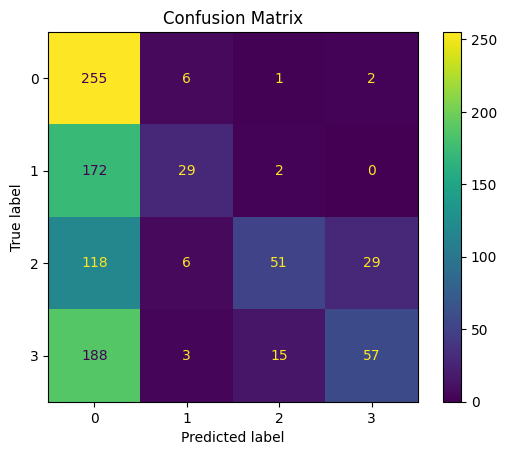

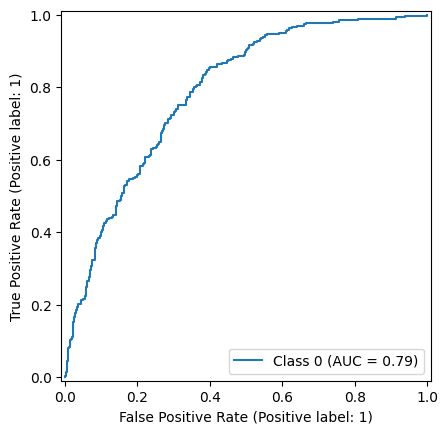

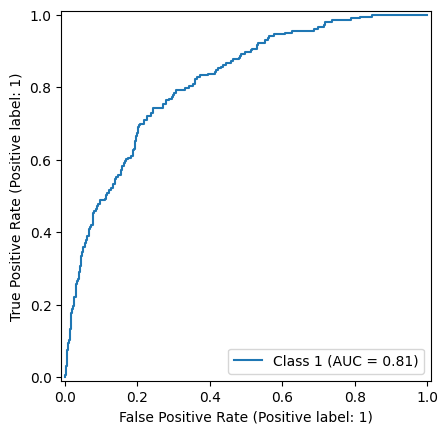

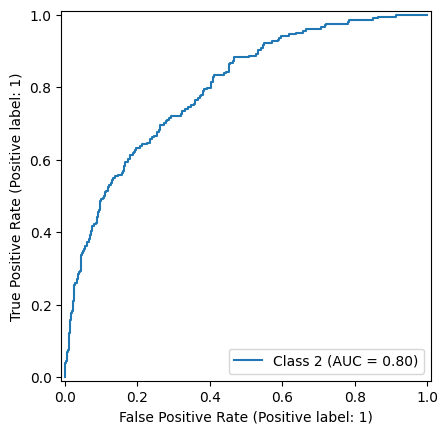

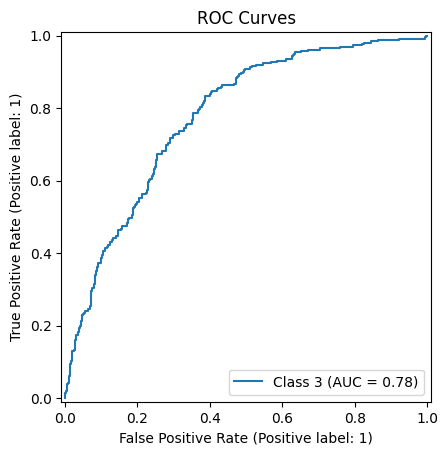

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# get predictions
y_prob = model.predict(X_val)
y_pred = y_prob.argmax(axis=1)
y_true = y_val.argmax(axis=1)

# plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.title("Confusion Matrix")
plt.show()

# ROC curves for each class
for i in range(y_val.shape[1]):
    RocCurveDisplay.from_predictions(y_val[:, i], y_prob[:, i], name=f"Class {i}")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()

In [ ]:
!pip uninstall -y qiskit qiskit-aer qiskit-machine-learning
!pip install "qiskit==1.0.2" \
            "qiskit-aer==0.13.2" \
            "qiskit-machine-learning==0.8.2" \
            "qiskit-ibmq-provider==0.20.2"

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance  # Now available
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import KerasConnector

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam

# augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Early stopping callback
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

def build_qcnn_layer(num_qubits=4):
    feature_map = ZZFeatureMap(num_qubits, reps=1)
    ansatz = RealAmplitudes(num_qubits, reps=1)
    qc = feature_map.compose(ansatz)

    backend = Aer.get_backend('aer_simulator')

    qnn = CircuitQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        quantum_instance=backend
    )
    return KerasConnector(qnn)


# QCNN model
tf.keras.backend.clear_session()
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]
num_qubits = 4

inputs = layers.Input(shape=input_shape)
x = data_augmentation(inputs)

# Classical feature extractor (3 separable conv blocks)
x = layers.SeparableConv2D(32, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(2)(x)

x = layers.SeparableConv2D(64, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(2)(x)

x = layers.SeparableConv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(2)(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(num_qubits, activation=None)(x)

# Quantum layer
qcnn_layer = build_qcnn_layer(num_qubits)
x = qcnn_layer(x)

# classification
y = layers.Dense(num_classes, activation='softmax')(x)

qcnn_model = models.Model(inputs=inputs, outputs=y)
qcnn_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
qcnn_model.summary()

# Train QCNN
history_qcnn = qcnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)

SyntaxError: invalid syntax (<ipython-input-55-87d206aa4cd0>, line 1)